Q1. **Image Reconstruction** - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates $(X, Y)$ to the pixel colors $(R, G, B)$. Here, $(X, Y)$ represents the coordinates of the pixels, and $(R, G, B)$ represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images. **[1.5 Mark]**

**Answer: Loading environment and image:**

Boy.jpeg exists
torch.Size([3, 768, 1344])


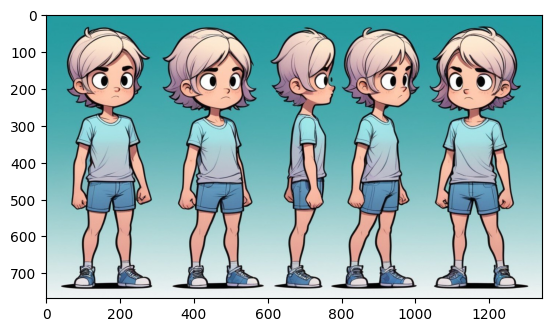

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
#%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    #%pip install einops
    from einops import rearrange
#Checking if the image exist 
if os.path.exists('Boy.jpeg'):
    print('Boy.jpeg exists')


# Read in a image from torchvision
img = torchvision.io.read_image("Boy.jpeg")
print(img.shape)
#Show image
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

**Reshaping the image and converting pixels to a 2-D array**

In [10]:
from sklearn import preprocessing
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

(3, 768, 1344)


tensor([[[0.1294, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
         [0.1294, 0.1294, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
         [0.1294, 0.1294, 0.1333,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.9373, 0.9373, 0.9373,  ..., 0.9373, 0.9373, 0.9373],
         [0.9373, 0.9373, 0.9373,  ..., 0.9412, 0.9412, 0.9412],
         [0.9373, 0.9373, 0.9373,  ..., 0.9412, 0.9412, 0.9412]],

        [[0.6118, 0.6157, 0.6157,  ..., 0.6157, 0.6157, 0.6157],
         [0.6118, 0.6118, 0.6157,  ..., 0.6157, 0.6157, 0.6157],
         [0.6118, 0.6118, 0.6157,  ..., 0.6157, 0.6157, 0.6157],
         ...,
         [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
         [0.9529, 0.9529, 0.9529,  ..., 0.9569, 0.9569, 0.9569],
         [0.9529, 0.9529, 0.9529,  ..., 0.9569, 0.9569, 0.9569]],

        [[0.6314, 0.6353, 0.6353,  ..., 0.6353, 0.6353, 0.6353],
         [0.6314, 0.6314, 0.6353,  ..., 0.6353, 0.6353, 0.6353],
         [0.6314, 0.6314, 0.6353,  ..., 0.6353, 0.6353, 0.

**Creating Coordinate map**

In [12]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y
Boy_X, Boy_Y = create_coordinate_map(img_scaled)

# print(Boy_X.shape, Boy_Y.shape)

torch.Size([1032192, 2]) torch.Size([1032192, 3])
tensor([[0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00],
        [0.0000e+00, 2.0000e+00],
        ...,
        [7.6700e+02, 1.3410e+03],
        [7.6700e+02, 1.3420e+03],
        [7.6700e+02, 1.3430e+03]])


**Scaling the created X label(Boy_X) and defining the Linear Model**

In [13]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Boy_X.cpu())

# Scale the X coordinates
Boy_X_scaled = scaler_X.transform(Boy_X.cpu())

# Move the scaled X coordinates to the GPU
Boy_X_scaled = torch.tensor(Boy_X_scaled).to(device)

# Set to dtype float32
Boy_X_scaled = Boy_X_scaled.float()

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

**Train The Model**

In [14]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()
train(net, 0.01, Boy_X_scaled, Boy_Y, 1000)


Epoch 0 loss: 0.922680
Epoch 100 loss: 0.129726
Epoch 200 loss: 0.060694
Epoch 300 loss: 0.057839
Epoch 400 loss: 0.057808
Epoch 500 loss: 0.057808
Epoch 600 loss: 0.057808
Epoch 700 loss: 0.057808
Epoch 800 loss: 0.057808
Epoch 900 loss: 0.057808


0.05780772492289543

**Plot of Reconstructed Image and Defining RMSE and PSNR**

In [38]:

def calculate_rmse(original_img, reconstructed_img):
    """Calculate Root Mean Squared Error (RMSE) between two images."""
    # Ensure both images have the same shape
    if original_img.shape != reconstructed_img.shape:
        raise ValueError(f"Shape mismatch: original_img.shape = {original_img.shape}, reconstructed_img.shape = {reconstructed_img.shape}")
    
    mse = F.mse_loss(reconstructed_img, original_img)
    rmse = torch.sqrt(mse)
    return rmse.item()

def calculate_psnr(original_img, reconstructed_img):
    """Calculate Peak Signal-to-Noise Ratio (PSNR) between two images."""
    mse = F.mse_loss(reconstructed_img, original_img)
    if mse == 0:
        return float('inf')
    max_pixel_value = 1.0  # Assuming the image is normalized between 0 and 1
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()


RMSE: 0.24043236157236006
PSNR: 12.380141556479739 dB


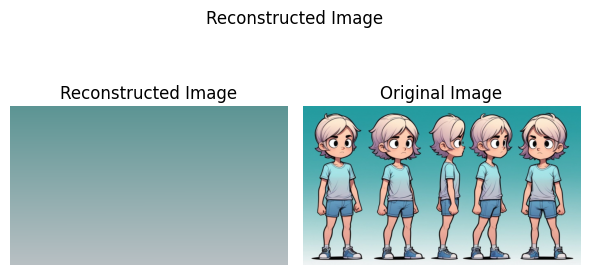

In [45]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        # print(outputs.shape)
        outputs = outputs.reshape(height, width,num_channels )
        # outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    def calculate_rmse(outputs, original):
        mse = torch.mean((outputs - original) ** 2).item()
        rmse = np.sqrt(mse)
        return rmse
    # Assuming your images are tensors in the format (C, H, W) and have been moved to CPU
    output_image = outputs.cpu()
    original_image = original_img.cpu().permute(1, 2, 0)  # Convert to (H, W, C) format if needed

    # If needed, normalize to range [0, 1] for PSNR calculation
    output_image = torch.clamp(output_image, 0, 1)
    original_image = torch.clamp(original_image, 0, 1)

    # Calculate RMSE and PSNR
    rmse_value = calculate_rmse(output_image, original_image)
    psnr_value = calculate_psnr(output_image, original_image)

    print(f"RMSE: {rmse_value}")
    print(f"PSNR: {psnr_value} dB")
    
plot_reconstructed_and_original_image(img_scaled, net, Boy_X_scaled, title="Reconstructed Image")